# Makemore MLP

### Using an MLP framework with an embedding space lookup table and variable-length letter context.

In [460]:
import torch
import random
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [461]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [462]:
chars = sorted(set(''.join(words)))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [463]:
context_length = 3
context = [0] * context_length

X, Y = [], []
random.shuffle(words) # shuffle the dataset

for w in words:    
    for char in w + '.':
        X.append(context)
        Y.append(stoi[char])  
        context = context[1:] + [stoi[char]]
        
X, Y = torch.tensor(X), torch.tensor(Y)

n1, n2 = int(len(X)*0.8), int(len(X)*0.9)
Xtr, Ytr = X[:n1], Y[:n1]
Xval, Yval = X[n1:n2], Y[n1:n2]
Xtest, Ytest = X[n2:], Y[n2:]

In [464]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

### Embedding Space
We will start by using an embedding space of length two vectors for each letter.

In [465]:
# params
C = torch.randn((27, 2), requires_grad=True)
W1 = torch.randn((6, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

n = len(X)

In [466]:
# forward pass
emb = C[X].view(-1, 6)
h = (emb @ W1 + b1).tanh()
logits = h @ W2 + b2

# calculating loss
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7858, grad_fn=<NllLossBackward0>)

In [467]:
emb.shape

torch.Size([228146, 6])

In [468]:
# training loop
NUM_ITERS = 100
lr = 1

for i in range(NUM_ITERS):
    
    # forward pass
    emb = C[X].view(-1, 6)
    h = (emb @ W1 + b1).tanh()
    logits = h @ W2 + b2

    # calculating loss
    loss = F.cross_entropy(logits, Y)
    
    # clearing old gradients
    for p in parameters:
        p.grad = None
    
    # backprop & update
    loss.backward()
    
    for p in parameters:
        p.data -= lr * p.grad
    
print(loss.item())

3.603555917739868


Notice that this is relatively slow, since we are doing a forward pass with all 200k+ data points and only then backpropagating with their gradients. In theory, we should be able to use exactly one data point, then calculate the loss and backpropagate with that one point to adjust our params. This would allow us to obtain a lower loss (and possibly a less noisy gradient step) when we use our next data point. However, notice this trade off. Using the gradient from one data point is too noisy and while using all of the data points is too slow/compute intensive. We would like an accurate (not-noisy) gradient, while also being able to take our gradient steps. We can compromise by using SGD on a minibatch of data, using (usually some multiple of 2) data points and using this (now significantly less noisy signal) to take our gradient step while also being multiple orders of magnitude faster. Turns out that in this way, taking more (slightly less accurate steps) gets us further than taking fewer/slower, precisely calculated steps. (SGD as a metaphor for life and perfectionism?)

### Minibatch Implementation

In [469]:
# reset params to retrain
C = torch.randn((27, 2), requires_grad=True)
W1 = torch.randn((6, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

n = len(X)

In [470]:
# minibatch training loop
NUM_ITERS = 10000
lr = .01

for i in range(NUM_ITERS):
    
    # minibatch indices
    idxs = torch.randint(0, n, (32,))
    
    # forward pass
    emb = C[X[idxs]].view(-1, 6)
    h = (emb @ W1 + b1).tanh()
    logits = h @ W2 + b2

    # calculating loss
    loss = F.cross_entropy(logits, Y[idxs])
    
    # clearing old gradients
    for p in parameters:
        p.grad = None
    
    # backprop & update
    loss.backward()
    
    for p in parameters:
        p.data -= lr * p.grad
    
print(loss.item())

2.5903360843658447


In [471]:
# loss on entire dataset
emb = C[X].view(-1, 6)
h = (emb @ W1 + b1).tanh()
logits = h @ W2 + b2

# calculating loss
loss = F.cross_entropy(logits, Y)
loss

tensor(2.6971, grad_fn=<NllLossBackward0>)

We're going to do a learning-rate search. First we will do some initial loss convergence testing to determine a reasonable range. We're assuming the distribtion for a good lr is unimodal (relatively speaking, at least).

In [472]:
lr_initial_test = torch.pow(10, torch.arange(-5, 5, 1).float())
lr_initial_test

tensor([1.0000e-05, 1.0000e-04, 1.0000e-03, 1.0000e-02, 1.0000e-01, 1.0000e+00,
        1.0000e+01, 1.0000e+02, 1.0000e+03, 1.0000e+04])

In [473]:
def lr_test(lr):
    # minibatch training loop
    NUM_ITERS = 1000
    losses = []
    
    # reset params to retrain
    C = torch.randn((27, 2), requires_grad=True)
    W1 = torch.randn((6, 100), requires_grad=True)
    b1 = torch.randn(100, requires_grad=True)
    W2 = torch.randn((100, 27), requires_grad=True)
    b2 = torch.randn(27, requires_grad=True)
    parameters = [C, W1, b1, W2, b2]

    n = len(X)

    for i in range(NUM_ITERS):

        # minibatch indices
        idxs = torch.randint(0, n, (32,))

        # forward pass
        emb = C[X[idxs]].view(-1, 6)
        h = (emb @ W1 + b1).tanh()
        logits = h @ W2 + b2

        # calculating loss
        loss = F.cross_entropy(logits, Y[idxs])
        losses.append(loss)

        # clearing old gradients
        for p in parameters:
            p.grad = None

        # backprop & update
        loss.backward()

        for p in parameters:
            p.data -= lr * p.grad

    return losses

In [474]:
losses = []
for lr in lr_initial_test:
    losses.append(lr_test(lr))

In [475]:
with torch.no_grad():
    for i in range():
        plt.plot(np.arange(1000), losses[i], label=f"lr={lr_initial_test[i]}")
    plt.legend()
    plt.show()

TypeError: range expected 1 argument, got 0

Since the highest and lowest learning rates don't converge, we remove them from the plot so that we can scale down and see what is happening with the relevant values.

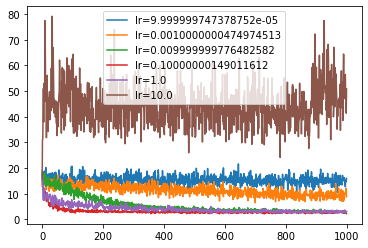

In [213]:
with torch.no_grad():
    for i in range(1, 7):
        plt.plot(np.arange(1000), losses[i], label=f"lr={lr_initial_test[i]}")
    plt.legend()
    plt.show()

Here, we see that only really the $\text{learning rates} \in [0.001, 1]$ converge and that the learning rate of 0.2 seems to do so in the most stable fashion to the lowest value. We could further refine our search and see how the lossses converge on a more dense region of our new interval.

#### Note on the train, val, test split: 
training data --> train model parameters \
val/dev data  --> train hyperparameters \
test data     --> test model (very infrequently)

#### On Model Size and Under/Overfitting

Often, if the loss on the training set and val set is the same or if the loss on the val set is slightly lower than the training let, we have underfit and we can expect to see an improvement in performance (decrease in loss), if we increase the size of the model (more hidden layers, larger hidden layers, etc). If we do this and we don't see any improvement in performance then we could either (1) not be optimizing our larger network correctly, or (2) there may be a bottleneck in another part of our model.

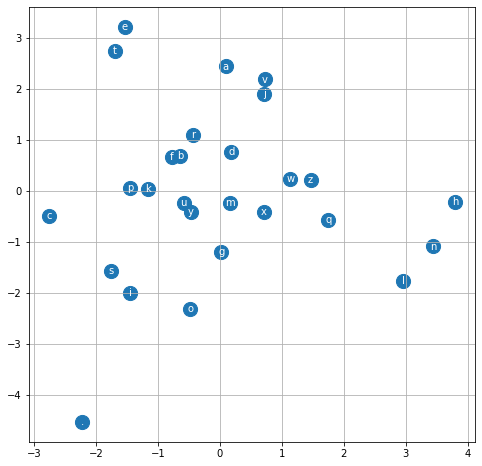

In [384]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Notice that these embeddings display some notable structure. All of the vowels are grouped on the middle left hand side. Further, the '.' and 'q' have been embedded as unique, which is qualitatively true in my understanding of English.

In [373]:
# reset params to retrain
C = torch.randn((27, 15), requires_grad=True)
W1 = torch.randn((45, 250), requires_grad=True)
b1 = torch.randn(250, requires_grad=True)
W2 = torch.randn((250, 250), requires_grad=True)
b2 = torch.randn(250 , requires_grad=True)
W3 = torch.randn((250, 27), requires_grad=True)
b3 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2, W3, b3]

n = len(Xtr)

In [374]:
# minibatch training loop
NUM_ITERS = 300000

for i in range(NUM_ITERS):
    
    # minibatch indices
    idxs = torch.randint(0, n, (32,))
    
    # forward pass
    emb = C[Xtr[idxs]].view(-1, 45)
    h = (emb @ W1 + b1).tanh()
    logits = ((h @ W2 + b2).tanh()) @ W3 + b3

    # calculating loss
    loss = F.cross_entropy(logits, Ytr[idxs])
    
    # clearing old gradients
    for p in parameters:
        p.grad = None
    
    # backprop & update
    loss.backward()
    
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
print(loss.item())

1.8803789615631104


In [376]:
# loss on val set
emb = C[Xval].view(-1, 45)
h = (emb @ W1 + b1).tanh()
logits = ((h @ W2 + b2).tanh()) @ W3 + b3

# calculating loss
loss = F.cross_entropy(logits, Yval)
loss.item()

2.187154531478882

In [459]:
NUM_SAMPLES = 10
context = [0] * context_length

for _ in range(NUM_SAMPLES):
    sample = []
    
    while True:
        emb = C[context].view(1, 45)
        h = (emb @ W1 + b1).tanh()
        logits = (((h @ W2) + b2).tanh() @ W3) + b3
        probs = F.softmax(logits, dim = 1)
        
        idx = torch.multinomial(probs, num_samples=1).item()
        sample.append(idx)
        context = context[1:] + [idx]
        
        if idx == 0:
            break
        
    print(''.join(itos[idx] for idx in sample))
    

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x27 and 45x27)

### Exercises

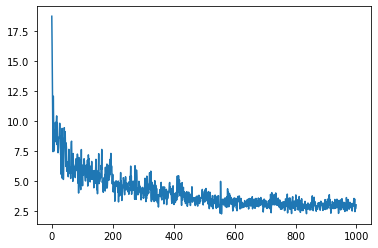

In [409]:
with torch.no_grad():
    plt.plot(np.arange(len(losses[5])), losses[5])

In [410]:
import math
math.log(1/27.0)

-3.295836866004329

Note on Initialization and Loss Graphs: \

Notice the hockey stick appearance of the loss curve above. This tells us that the initialization of our parameters in our network is not very good (since it gives such a high loss). Lets think about what it means to have a good loss in this problem and what we should expect from our model before training. Before training, our model should have no information about which characters are more likely than others, and should thus output a roughly uniform distribution over our alphabet. Doing some quick math, this tells us that we should expect a loss of around $-log(\frac{1}{27}) \approx 3.2958 $. Notice in the graph above though, that we have a loss of more than 17.5. This means that our model is initially outputting probabilities with a high variance (very bold/confident in its predictions), while being wrong most of the time. Notice that we obtain our probabilites from a softmax, so in order to get a nearly uniform distribution, we would need nearly uniform logit values. This can be done by multiplying our bias and weight matrices (all or just the last couple) by some small constants to squish their values to around zero. In theory, we could also just set one pair of weight and bias vectors to exactly all zeros and this should give us a perfectly uniform distribution. However, we must be careful when doing this, since it can cause unwanted symmetry in the network, as the gradients will propogate backwards exactly the same way throughout the entire network. In this way, we say that some variance in the weights is necessary to "break the symmetry of the network". \

I will now demonstrate some of the above ideas.

In [418]:
# reset params to retrain
C = torch.randn((27, 2), requires_grad=True)
W1 = torch.randn((6, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

n = len(X)

In [419]:
# minibatch training loop
NUM_ITERS = 1000
lr = .01

for i in range(NUM_ITERS):
    
    # minibatch indices
    idxs = torch.randint(0, n, (32,))
    
    # forward pass
    emb = C[X[idxs]].view(-1, 6)
    h = (emb @ W1 + b1).tanh()
    logits = h @ W2 + b2

    # calculating loss
    loss = F.cross_entropy(logits, Y[idxs])
    
    # clearing old gradients
    for p in parameters:
        p.grad = None
    
    # backprop & update
    loss.backward()
    
    for p in parameters:
        p.data -= lr * p.grad
    
    print(loss.item())
    
    break

17.055200576782227


Here, notice that the initial loss is much higher than the expected 3.29... \
Now, if we set W2, b2 to all zeros, notice what happens.

In [420]:
# reset params to retrain
C = torch.randn((27, 2), requires_grad=True)
W1 = torch.randn((6, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
W2 = torch.zeros((100, 27), requires_grad=True)
b2 = torch.zeros(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

n = len(X)

In [421]:
# minibatch training loop
NUM_ITERS = 1000
lr = .01

for i in range(NUM_ITERS):
    
    # minibatch indices
    idxs = torch.randint(0, n, (32,))
    
    # forward pass
    emb = C[X[idxs]].view(-1, 6)
    h = (emb @ W1 + b1).tanh()
    logits = h @ W2 + b2

    # calculating loss
    loss = F.cross_entropy(logits, Y[idxs])
    
    # clearing old gradients
    for p in parameters:
        p.grad = None
    
    # backprop & update
    loss.backward()
    
    for p in parameters:
        p.data -= lr * p.grad
    
    print(loss.item())
    
    break

3.295837163925171


Now, we get a loss of exactly 3.29, as expected from a uniform distribution.
Now, let's see what happens if we set all of our weights and biases to all zeros and try to train.

In [432]:
# reset params to retrain
C = torch.zeros((27, 2), requires_grad=True)
W1 = torch.zeros((6, 100), requires_grad=True)
b1 = torch.zeros(100, requires_grad=True)
W2 = torch.zeros((100, 27), requires_grad=True)
b2 = torch.zeros(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

n = len(X)

In [433]:
# minibatch training loop
NUM_ITERS = 10000
lr = .01

for i in range(NUM_ITERS):
    
    # minibatch indices
    idxs = torch.randint(0, n, (32,))
    
    # forward pass
    emb = C[X[idxs]].view(-1, 6)
    h = (emb @ W1 + b1).tanh()
    logits = h @ W2 + b2

    # calculating loss
    loss = F.cross_entropy(logits, Y[idxs])
    
    # clearing old gradients
    for p in parameters:
        p.grad = None
    
    # backprop & update
    loss.backward()
    
    for p in parameters:
        p.data -= lr * p.grad
    
    if i % 1000 == 0:
        print(loss.item())


3.295837163925171
2.9847047328948975
3.017155170440674
2.6724843978881836
2.835339307785034
2.678118944168091
2.960329532623291
2.6650705337524414
2.503972291946411
2.767963171005249


Though this initialization does converge (because of the presence of the tanh which allows the gradient to be nonzero), it may not in other cases and so all zero initialization is not recommended. We will now use a more stable initializatio of small values that are not actually zero and see how this affects our achieved loss.

In [442]:
# reset params to retrain
C = torch.randn((27, 15), requires_grad=True)
W1 = torch.randn((45, 250), requires_grad=True)
b1 = torch.randn(250, requires_grad=True)

W2 = torch.randn((250, 250)) * 0.01
W2.requires_grad = True

b2 = torch.randn(250 , requires_grad=True)
W3 = torch.randn((250, 27), requires_grad=True)
b3 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2, W3, b3]

n = len(Xtr)

In [443]:
# minibatch training loop
NUM_ITERS = 300000

for i in range(NUM_ITERS):
    
    # minibatch indices
    idxs = torch.randint(0, n, (32,))
    
    # forward pass
    emb = C[Xtr[idxs]].view(-1, 45)
    h = (emb @ W1 + b1).tanh()
    logits = ((h @ W2 + b2).tanh()) @ W3 + b3

    # calculating loss
    loss = F.cross_entropy(logits, Ytr[idxs])
    
    # clearing old gradients
    for p in parameters:
        p.grad = None
    
    # backprop & update
    loss.backward()
    
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
print(loss.item())

2.0388288497924805


In [444]:
# loss on val set
emb = C[Xval].view(-1, 45)
h = (emb @ W1 + b1).tanh()
logits = ((h @ W2 + b2).tanh()) @ W3 + b3

# calculating loss
loss = F.cross_entropy(logits, Yval)
loss.item()

2.178805351257324

Notice that we achieve a slightly lower validation loss here since we get to spend more time training the actual difficult part of the model, instead of just spending the first couple iterations squishing the weights.

In [455]:
# reset params to retrain
C = torch.randn((27, 15), requires_grad=True)
W1 = torch.randn((45, 250), requires_grad=True)
b1 = torch.randn(250, requires_grad=True)

W2 = torch.randn((250, 27)) * 0.01
W2.requires_grad = True
b2 = torch.randn(27 , requires_grad=True)

W3 = torch.randn((45, 27), requires_grad=True)

parameters = [C, W1, b1, W2, b2, W3]

n = len(Xtr)

In [456]:
# minibatch training loop
NUM_ITERS = 300000

for i in range(NUM_ITERS):
    
    # minibatch indices
    idxs = torch.randint(0, n, (32,))
    
    # forward pass
    emb = C[Xtr[idxs]].view(-1, 45)
    h = (emb @ W1 + b1).tanh()
    logits = ((h @ W2 + b2).tanh()) + emb @ W3


    # calculating loss
    loss = F.cross_entropy(logits, Ytr[idxs])
    
    # clearing old gradients
    for p in parameters:
        p.grad = None
    
    # backprop & update
    loss.backward()
    
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
print(loss.item())

2.0473878383636475


In [458]:
# loss on val set
emb = C[Xval].view(-1, 45)
h = (emb @ W1 + b1).tanh()
logits = ((h @ W2 + b2).tanh()) + emb @ W3

# calculating loss
loss = F.cross_entropy(logits, Yval)
loss.item()

2.1723034381866455

Though this did not decrease the loss in any significant way, it we have addded a skip connection. It likely didn't help much since this model is not very deep to begin with.